In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
from torchsummary import summary
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import math
import os

#### 1- Load the data

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 50
batch_size = 64
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='cifar10_data/', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='cifar10_data/', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(train_dataset)
print(test_dataset)

dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
torch.Size([64, 3, 32, 32]) torch.Size([64])


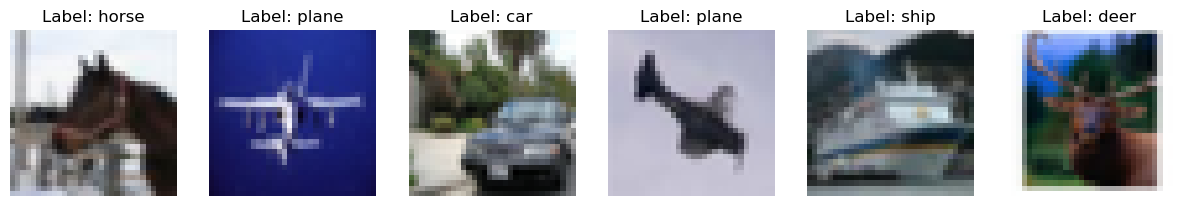

In [3]:
# Function to visualize samples
def visualize_samples(dataset, num_samples=6):
    # Get some random samples from the dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    samples = torch.utils.data.Subset(dataset, indices)
    
    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, (image, label) in enumerate(samples):
        image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
        image = image * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]  # Unnormalize for display
        image = np.clip(image, 0, 1)
        label = classes[label]
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Assuming train_dataset is defined and loaded with CIFAR-10 dataset
visualize_samples(train_dataset)

## Output Shape and Padding Equations

#### Parameters:
- **Input\_size**: Size of the input volume (height or width).
- **Padding**: Number of pixels added to each side of the input.
- **Dilation**: Spacing between kernel elements.
- **Kernel\_size**: Size of the convolution or pooling kernel.
- **Stride**: Number of pixels by which the filter or pooling window moves across the input.

### 1. Output Shape for Convolutional Layer
The output shape for a convolutional layer can be calculated using the following formula:

$$
\text{Output\_size} = \left\lfloor \frac{\text{Input\_size} + 2 \times \text{Padding} - \text{Dilation} \times (\text{Kernel\_size} - 1) - 1}{\text{Stride}} + 1 \right\rfloor
$$

### 2. Output Shape for Max Pooling Layer
The output shape for a max pooling layer can be calculated using the following formula:

$$
\text{Output\_size} = \left\lfloor \frac{\text{Input\_size} + 2 \times \text{Padding} - \text{Kernel\_size}}{\text{Stride}} \right\rfloor + 1
$$

### 3. Same Padding Calculation
To achieve "same" padding, where the output size is the same as the input size, the padding needed can be calculated using:

$$
\text{Padding} = \left( \frac{(\text{Stride} - 1) + \text{Dilation} \times (\text{Kernel\_size} - 1)}{2} \right)
$$


#### 2- Build the CNN

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 32, 16, 16)
        )
        
        # Convolutional Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # Output: (batch_size, 64, 14, 14)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 64, 7, 7)
        )
        
        # Convolutional Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # Output: (batch_size, 128, 5, 5)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 128, 2, 2)
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 2 * 2, out_features=256)  # Output: (batch_size, 256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # Output: (batch_size, 128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)  # Output: (batch_size, 10)
    
    def forward(self, x):
        out = self.layer1(x)  # After layer1
        out = self.layer2(out)  # After layer2
        out = self.layer3(out)  # After layer3
        out = out.view(out.size(0), -1)  # Flatten: (batch_size, 128 * 2 * 2)
        out = self.fc1(out)  # After fc1
        out = self.fc2(out)  # After fc2
        out = self.fc3(out)  # After fc3
        return out


model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### 3- Callbacks

In [5]:
def save_checkpoint(model, epoch, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

In [6]:
def early_stopping(loss, accuracy, loss_threshold, acc_threshold, patience, stop_counter):
    if loss < loss_threshold or accuracy > acc_threshold:
        stop_counter += 1
        if stop_counter >= patience:
            print("Early stopping triggered")
            return True, stop_counter
    else:
        stop_counter = 0
    return False, stop_counter

#### 4- Train the CNN

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    stop_counter = 0
    patience = 3
    loss_threshold = 0.25
    acc_threshold = 0.90  # Example threshold for accuracy
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #if (i+1) % 100 == 0:
            #    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Callbacks
        #save_checkpoint(model, epoch)
        stop, stop_counter = early_stopping(avg_loss, accuracy, loss_threshold, acc_threshold, patience, stop_counter)
        if stop:
            break

train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch [1/50], Step [782/782], Loss: 1.2225, Accuracy: 0.5628
Epoch [2/50], Step [782/782], Loss: 0.9146, Accuracy: 0.6823
Epoch [3/50], Step [782/782], Loss: 0.7793, Accuracy: 0.7275
Epoch [4/50], Step [782/782], Loss: 0.6804, Accuracy: 0.7651
Epoch [5/50], Step [782/782], Loss: 0.6004, Accuracy: 0.7922
Epoch [6/50], Step [782/782], Loss: 0.5437, Accuracy: 0.8107
Epoch [7/50], Step [782/782], Loss: 0.4832, Accuracy: 0.8306
Epoch [8/50], Step [782/782], Loss: 0.4322, Accuracy: 0.8496
Epoch [9/50], Step [782/782], Loss: 0.3867, Accuracy: 0.8638
Epoch [10/50], Step [782/782], Loss: 0.3466, Accuracy: 0.8774
Epoch [11/50], Step [782/782], Loss: 0.3123, Accuracy: 0.8888
Epoch [12/50], Step [782/782], Loss: 0.2743, Accuracy: 0.9033
Epoch [13/50], Step [782/782], Loss: 0.2611, Accuracy: 0.9069
Epoch [14/50], Step [782/782], Loss: 0.2324, Accuracy: 0.9164
Early stopping triggered


#### 5- Evaluate the CNN

In [8]:
def evaluate(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

evaluate(model, test_loader, device)

Accuracy of the model on the 10000 test images: 72.90%


# Solve overfitting using Dropouts and Regularization
#### The model accuracy on the training set (91.6%) is much higher than its accuracy on the test set (72.9%).

In [10]:
# Define the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 32, 16, 16)
            nn.Dropout(0.2)  # Dropout with a probability of 0.2
        )
        
        # Convolutional Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # Output: (batch_size, 64, 14, 14)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 64, 7, 7)
            nn.Dropout(0.2),  # Dropout with a probability of 0.2
        )
        
        # Convolutional Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # Output: (batch_size, 128, 5, 5)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 128, 2, 2)
            nn.Dropout(0.2)  # Dropout with a probability of 0.2
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 2 * 2, out_features=256)  # Output: (batch_size, 256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # Output: (batch_size, 128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)  # Output: (batch_size, 10)
    
    def forward(self, x):
        out = self.layer1(x)  # After layer1
        out = self.layer2(out)  # After layer2
        out = self.layer3(out)  # After layer3
        out = out.view(out.size(0), -1)  # Flatten: (batch_size, 128 * 2 * 2)
        out = self.fc1(out)  # After fc1
        out = self.fc2(out)  # After fc2
        out = self.fc3(out)  # After fc3
        return out


model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [11]:
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch [1/50], Step [782/782], Loss: 1.4023, Accuracy: 0.4902
Epoch [2/50], Step [782/782], Loss: 1.1144, Accuracy: 0.6086
Epoch [3/50], Step [782/782], Loss: 1.0145, Accuracy: 0.6436
Epoch [4/50], Step [782/782], Loss: 0.9437, Accuracy: 0.6709
Epoch [5/50], Step [782/782], Loss: 0.8882, Accuracy: 0.6902
Epoch [6/50], Step [782/782], Loss: 0.8453, Accuracy: 0.7044
Epoch [7/50], Step [782/782], Loss: 0.8138, Accuracy: 0.7157
Epoch [8/50], Step [782/782], Loss: 0.7875, Accuracy: 0.7268
Epoch [9/50], Step [782/782], Loss: 0.7586, Accuracy: 0.7365
Epoch [10/50], Step [782/782], Loss: 0.7370, Accuracy: 0.7446
Epoch [11/50], Step [782/782], Loss: 0.7194, Accuracy: 0.7491
Epoch [12/50], Step [782/782], Loss: 0.7053, Accuracy: 0.7539
Epoch [13/50], Step [782/782], Loss: 0.6875, Accuracy: 0.7612
Epoch [14/50], Step [782/782], Loss: 0.6796, Accuracy: 0.7641
Epoch [15/50], Step [782/782], Loss: 0.6676, Accuracy: 0.7659
Epoch [16/50], Step [782/782], Loss: 0.6557, Accuracy: 0.7718
Epoch [17/50], St

In [12]:
evaluate(model, test_loader, device)

Accuracy of the model on the 10000 test images: 79.67%


# Using a Deeper Network

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(0.2)  # Dropout with a probability of 0.25
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Output: (batch_size, 64, 32, 32)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 64, 16, 16)
            nn.Dropout(0.2)  # Dropout with a probability of 0.2
        )
        
        # Convolutional Layer 2
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # Output: (batch_size, 128, 14, 14)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 128, 7, 7)
            nn.Dropout(0.2),  # Dropout with a probability of 0.2
        )
        
        # Convolutional Layer 3
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),  # Output: (batch_size, 256, 5, 5)
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 256, 2, 2)
            nn.Dropout(0.2)  # Dropout with a probability of 0.2
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=256 * 2 * 2, out_features=256)  # Output: (batch_size, 256)
        self.dropout1 = nn.Dropout(0.2)  # Dropout with a probability of 0.2
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # Output: (batch_size, 128)
        self.dropout2 = nn.Dropout(0.2)  # Dropout with a probability of 0.2
        self.fc3 = nn.Linear(in_features=128, out_features=10)  # Output: (batch_size, 10)
    
    def forward(self, x):
        out = self.layer1(x)  # After layer1
        out = self.layer2(out)  # After layer2
        out = self.layer3(out)  # After layer3
        out = self.layer4(out)  # After layer4
        out = out.view(out.size(0), -1)  # Flatten: (batch_size, 256 * 2 * 2)
        out = self.fc1(out)  # After fc1
        out = self.dropout1(out)  # After dropout1
        out = self.fc2(out)  # After fc2
        out = self.dropout2(out)  # After dropout2
        out = self.fc3(out)  # After fc3
        return out


model = CNN().to(device)

# Display the model summary
summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 14, 14]          73,856
      BatchNorm2d-11          [-1, 128, 14, 14]             256
             ReLU-12          [-1, 128, 14, 14]               0
        MaxPool2d-13            [-1, 128, 7, 7]               0
          Dropout-14            [-1, 12

In [14]:
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch [1/50], Step [782/782], Loss: 1.3699, Accuracy: 0.5025
Epoch [2/50], Step [782/782], Loss: 1.0018, Accuracy: 0.6498
Epoch [3/50], Step [782/782], Loss: 0.8670, Accuracy: 0.6996
Epoch [4/50], Step [782/782], Loss: 0.7793, Accuracy: 0.7308
Epoch [5/50], Step [782/782], Loss: 0.7034, Accuracy: 0.7582
Epoch [6/50], Step [782/782], Loss: 0.6523, Accuracy: 0.7744
Epoch [7/50], Step [782/782], Loss: 0.6153, Accuracy: 0.7877
Epoch [8/50], Step [782/782], Loss: 0.5751, Accuracy: 0.7989
Epoch [9/50], Step [782/782], Loss: 0.5506, Accuracy: 0.8090
Epoch [10/50], Step [782/782], Loss: 0.5175, Accuracy: 0.8217
Epoch [11/50], Step [782/782], Loss: 0.5007, Accuracy: 0.8275
Epoch [12/50], Step [782/782], Loss: 0.4779, Accuracy: 0.8352
Epoch [13/50], Step [782/782], Loss: 0.4633, Accuracy: 0.8386
Epoch [14/50], Step [782/782], Loss: 0.4489, Accuracy: 0.8425
Epoch [15/50], Step [782/782], Loss: 0.4312, Accuracy: 0.8509
Epoch [16/50], Step [782/782], Loss: 0.4243, Accuracy: 0.8507
Epoch [17/50], St

In [15]:
evaluate(model, test_loader, device)

Accuracy of the model on the 10000 test images: 83.86%
